100%|██████████| 200/200 [00:00<00:00, 5710.38it/s]


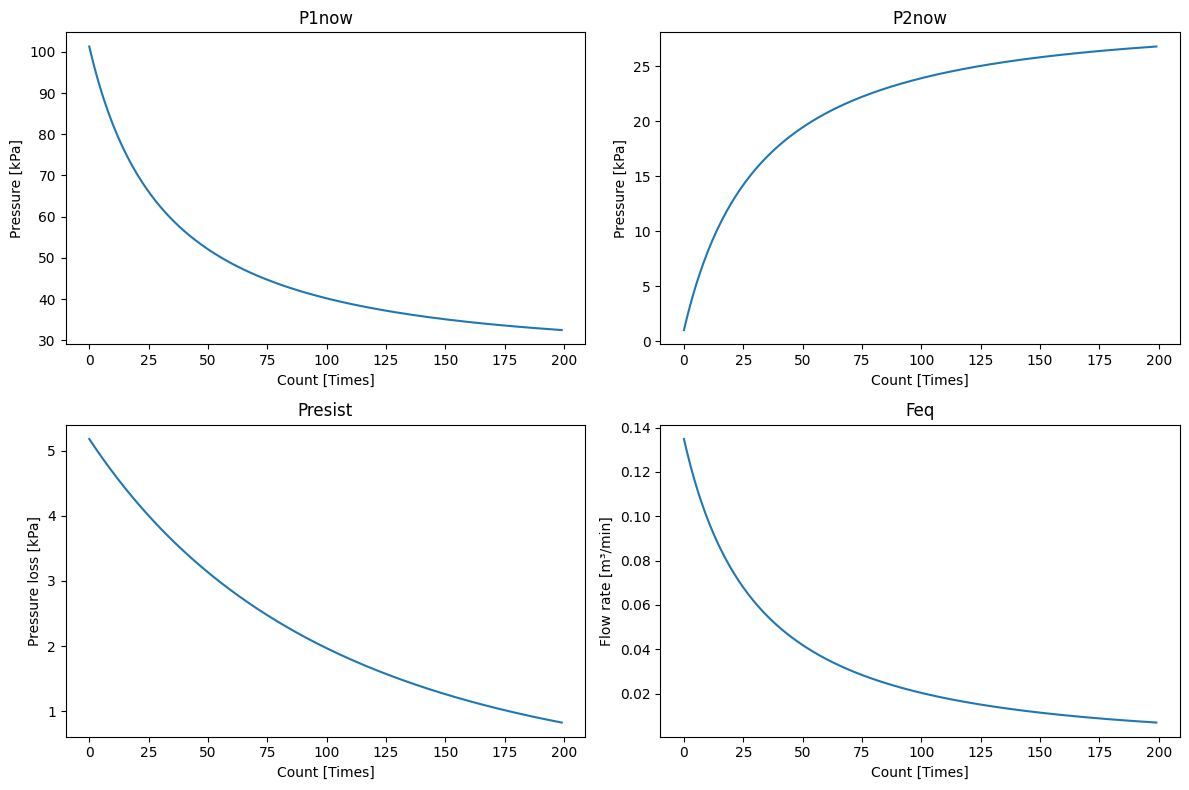

In [2]:
# Required packages
# pip install numpy
# pip install matplotlib
# pip install CoolProp
# pip install tqdm

import numpy as np
import matplotlib.pyplot as plt
from CoolProp.CoolProp import PropsSI
from tqdm import tqdm

# Initial parameters
Time = 0.2  # min
dt = 0.001  # min  #計算時間刻み
Count = int(Time/dt)
P0 = 101.3  # kPa
P1 = 101.3  # kPa
P1now = P1
dq1 = 0  # mol
P2 = 1  # kPa
P2now = P2
dq2 = 0  # mol
Presist = 0  # kPa
V1 = 0.006  # m3
V2 = 0.006  # m3
Va = 0.010  # m3   #ここの値も適当設定
T1now = 288  # K
T2now = 288  # K
R = 8.314  # J/mol/K
k = 5   #ここの値は適当設定
D = 0.010  # m
L = 1.0  # m   #ここの値も適当設定
S = np.pi * D**2 / 4

# Arrays for storing results
P1_history = []
P2_history = []
Presist_history = []
Feq_history = []

def calculate_flow_parameters(P1now, P2now, T1now):
    # Function to calculate flow parameters with convergence
    viscosity = PropsSI('V','T',T1now,'P',P1now*1000,'CO2')
    rho = PropsSI('D','T',T1now,'P',P1now*1000,'CO2')
    
    Presist_old = 0
    u_old = 0
    max_iterations = 100
    tolerance = 1e-6
    ###########################################################
    for i in range(max_iterations):
        dP = (P1now - P2now - Presist_old)*1000
        u = dP * D**2 / (32 * viscosity * L)
        Re = rho*abs(u)*D/viscosity
        lambda_f = 64/Re if Re != 0 else 0   #摩擦の理論式は層流を仮定している。正しくは乱流なので見直し必要
        Presist_new = lambda_f*L/D*u**2/(2*9.81)/1000
        
        if abs(Presist_new - Presist_old) < tolerance:
            break
            
        Presist_old = Presist_new
        u_old = u
    ###########################################################
    
    # 発散した場合は恒等関数
    
    return u, Presist_new

# Main calculation loop
for i in tqdm(range(Count)):
    # Calculate flow parameters
    u, Presist = calculate_flow_parameters(P1now, P2now, T1now)
    
    # Calculate mass transfer
    Feq = S * abs(u) / 60 * k
    FeqN = Feq * P1now / P0 #############################
    dn1 = FeqN * 1000 * dt /22.4 + dq1
    
    # Calculate pressure changes
    dP1 = R * T1now / V1 * dn1
    P1next = P1now - dP1/1000
    dn2 = dn1 - dq2
    dP2 = R * T2now / (V2 + Va) * dn2
    P2next = P2now + dP2/1000
    
    # Store results
    P1_history.append(P1now)
    P2_history.append(P2now)
    Presist_history.append(Presist)
    Feq_history.append(Feq)
    
    # Update values
    P1now = P1next
    P2now = P2next

# Convert lists to numpy arrays
P1_history = np.array(P1_history)
P2_history = np.array(P2_history)
Presist_history = np.array(Presist_history)
Feq_history = np.array(Feq_history)

# Create time points array
time_points = np.arange(len(P1_history))

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(time_points, P1_history)
plt.title('P1now')
plt.xlabel('Count [Times]')
plt.ylabel('Pressure [kPa]')

plt.subplot(2, 2, 2)
plt.plot(time_points, P2_history)
plt.title('P2now')
plt.xlabel('Count [Times]')
plt.ylabel('Pressure [kPa]')

plt.subplot(2, 2, 3)
plt.plot(time_points, Presist_history)
plt.title('Presist')
plt.xlabel('Count [Times]')
plt.ylabel('Pressure loss [kPa]')

plt.subplot(2, 2, 4)
plt.plot(time_points, Feq_history)
plt.title('Feq')
plt.xlabel('Count [Times]')
plt.ylabel('Flow rate [m³/min]')

plt.tight_layout()
plt.show()
